In [100]:
import sys
sys.path.append('/orions4-zfs/projects/lins2/Lin_Space/Git_Repos')
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

ValueError: GPU setup must happen before importing TensorFlow

In [101]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, points_extension, \
                                                 shape_net_core_synth_id_to_category

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs, accuracy_of_completion, \
                                           coverage_of_completion, save_reconstructions, \
                                           save_pc_prediction_stats, \
                                           paper_pc_completion_experiment_id_best_epoch
                                           
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud


from tf_lab.autopredictors.scripts.virt_scan_data import load_partial_pointclouds
import tf_lab.autopredictors.scripts.virt_scan_data as vscan
from general_tools.simpletons import indices_in_iterable

In [102]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
loss = 'chamfer'

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

incomplete_n_samples = 2048
complete_n_samples = 4096
max_training_epochs = 100

do_training = False
load_training_data = True
load_model_conf = True
do_evaluation = True
do_detailed_plotting = True

# experiment_id, best_epoch = paper_pc_completion_experiment_id_best_epoch(class_type, loss)

experiment_id = int(raw_input('Experiment Id.\n'))
experiment_name = str(experiment_id) + '_' + class_type + '_' + str(incomplete_n_samples) + '_' \
                  + str(complete_n_samples) + 'pts_' + loss


top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

complete_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/raw', \
                             str(complete_n_samples), class_syn_id)

partial_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Partial_PCs/Angela_synthetic', str(incomplete_n_samples))

n_input = [incomplete_n_samples, 3]
n_output = [complete_n_samples, 3]

train_dir = osp.join(top_data_dir, 'OUT/iccv/nn_models/testing')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

max_evaluation_epochs = max_training_epochs

Give me the class type.
chair
Experiment Id.
3


In [104]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

In [105]:
cmpl_file_names = pio.load_filenames_of_input_data(complete_pclouds_path, points_extension)
cmpl_pclouds, cmpl_model_names, cmpl_syn_ids = pio.load_crude_point_clouds(file_names=cmpl_file_names, n_threads=40)
assert(len(np.unique(cmpl_syn_ids)) == 1)
print '%d files containing complete point clouds were found.' % (len(cmpl_pclouds), )

6778 files containing complete point clouds were found.


In [106]:
train_list = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/train_test_splits/train_models_with_scan_id.txt'
partial_pclouds, partial_model_ids, partial_syn_ids = load_partial_pointclouds(train_list, partial_pclouds_path, 
                                                                               50, class_restriction=class_syn_id)
partial_model_names = np.array([i[0] for i in partial_model_ids], dtype=object)
partial_scan_ids = np.array([i[1] for i in partial_model_ids], dtype=object)
partial_unames = np.array(partial_model_names + '.' + partial_scan_ids + '.' + partial_syn_ids, dtype=object)

30000 partial point clouds were loaded.


In [107]:
test_list = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/train_test_splits/test_models_small_with_scan_id.txt'
test_pclouds, test_model_ids, test_syn_ids = load_partial_pointclouds(test_list, partial_pclouds_path, 
                                                                               50, class_restriction=class_syn_id)
test_model_names = np.array([i[0] for i in test_model_ids], dtype=object)
test_scan_ids = np.array([i[1] for i in test_model_ids], dtype=object)
test_unames = np.array(test_model_names + '.' + test_scan_ids + '.' + test_syn_ids, dtype=object)
matching_index = indices_in_iterable(cmpl_model_names, test_model_names)
assert(np.alltrue(matching_index != -1))
test_data = PointCloudDataSet(cmpl_pclouds[matching_index], noise=test_pclouds, labels=test_unames)

6000 partial point clouds were loaded.


In [108]:
matching_index = indices_in_iterable(cmpl_model_names, partial_model_names)
assert(np.alltrue(matching_index != -1))
full_pclouds_matched = cmpl_pclouds[matching_index]
train_data = PointCloudDataSet(full_pclouds_matched, noise=partial_pclouds, labels=partial_unames)

0.99169921875 0.641357421875


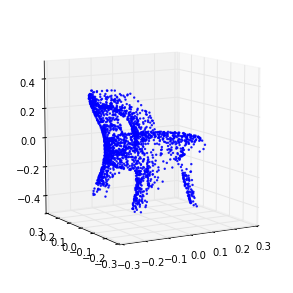

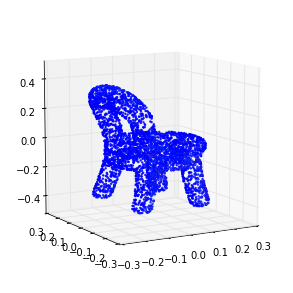

In [84]:
pp = train_data.next_batch(1)
pinc = pp[2].reshape(incomplete_n_samples, 3)
pcom = pp[0].reshape(complete_n_samples, 3)

score1 = accuracy_of_completion(pinc, pcom, 0.02, ret_dists=False)
score2, c2 = coverage_of_completion(pcom, pinc, 0.02, ret_dists=True)
print score1, score2
Point_Cloud(points=pinc).plot();
Point_Cloud(points=pcom).plot(c=c2);

In [85]:
train_data, val_data = vscan.make_validation_from_train_data(train_data, 0.05)

In [109]:
if load_model_conf:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:    
    encoder_args = {'n_filters': [128, 256, 512, 512],
                    'filter_sizes': [1, 1, 1, 1],
                    'strides': [1, 1, 1, 1],
                    'dropout_prob': 0.5,
                    'regularizer': 'L2',
                    'weight_decay': 0.1
                   }
    
    decoder_args = {'layer_sizes': [2048, np.prod(n_output)],
                    'regularizer': 'L2',
                    'weight_decay': 0.1
                   }
    
    conf = Conf(
                n_input = n_input,
                n_output = n_output,
                denoising = True,
                training_epochs = max_training_epochs,
                batch_size = 50,
                loss = loss,
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 1,
                learning_rate = 0.0005,
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                encoder_args = encoder_args,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args
               )
    
    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))
    
reset_tf_graph()
ae = PointNetAutoEncoder(experiment_name, conf)

                    batch_size: 50
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'layer_sizes': [1024, 12288]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {'filter_sizes': [1, 1, 1], 'n_filters': [64, 128, 1024], 'dropout_prob': 0.5, 'strides': [1, 1, 1]}
               experiment_name: 3_chair_2048_4096pts_chamfer
                 gauss_augment: None
                  is_denoising: True
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: chamfer
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [4096, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 1
                     train_dir: /orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/iccv/nn_models/testi

In [87]:
if do_training:
    fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a')
    ae.train(train_data, conf, log_file=fout)
    fout.close()

In [110]:
from tf_lab.autopredictors.scripts import minhyuk_data as minhyuk_loader

In [147]:
print minhyuk_loader.test_categories
incomplete_n_samples = 2048
complete_n_samples = 4096

from_manifold = False

category_id = 3
np.random.seed(42)
min_categ_name = minhyuk_loader.test_categories[category_id]
minhyuk_data, accuracies = minhyuk_loader.dataset_of_category(category_id, incomplete_n_samples, complete_n_samples, from_manifold)

['assembly_airplanes', 'assembly_bicycles', 'assembly_chairs', 'coseg_chairs', 'shapenet_tables']


In [148]:
minh_full_pc, minh_labels, minh_pc_inc = minhyuk_data.full_epoch_data()
test_data = PointCloudDataSet(minh_full_pc, labels=minh_labels, noise=minh_pc_inc)

[0.0, 0.0, 0.0]


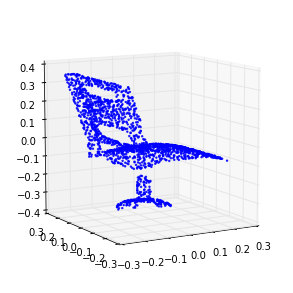

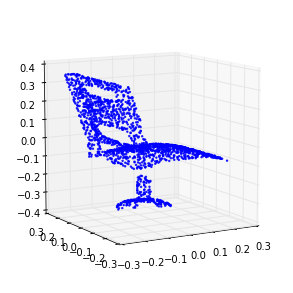

In [149]:
test = Point_Cloud(minh_full_pc[0])

gap = test.center_axis()[1]
print(gap)
Point_Cloud(minh_pc_inc[0]).rotate_z_axis_by_degrees(0).plot()

In [151]:
if do_evaluation:    
#     Pick the epoch that minimizes the loss on the validation dataset.
    #saved_epochs = np.array(read_saved_epochs(conf.train_dir))
    #allowable_epochs = saved_epochs[saved_epochs <= max_evaluation_epochs]
    #val_stats = eval_model(ae, conf, val_data, epochs=allowable_epochs, verbose=True)
    #val_loss = np.min(val_stats[:,1])
    #best_epoch = int(val_stats[np.argmin(val_stats[:,1]), 0])
    print 'Best epoch = %d.' % (best_epoch,)
    best_epoch = 95
    ae.restore_model(conf.train_dir, best_epoch)
    top_save_dir = osp.join(conf.train_dir, 'output', 'epoch_' + str(best_epoch))
    test_recon, test_loss, test_feed, test_ids, test_gt = ae.evaluate(test_data, conf)
    save_dir = osp.join(top_save_dir, 'test_predictions')

#     save_reconstructions(save_dir, test_recon, test_gt, test_feed, test_ids) # save ply files of test data.    
#     train_loss = ae.evaluate(train_data, conf)[1]
    
    # Report Accuracy and Coverage of test data.
    n_examples = len(test_recon)
    pred_scores = np.zeros((n_examples, 2))
    for i in xrange(n_examples):
        gt = test_gt[i]
        pred = test_recon[i] 
       # vis = Point_Cloud(points=pred).plot()
        pred_scores[i, 0] = accuracy_of_completion(pred, gt, thres=0.02, ret_dists=False)
        pred_scores[i, 1] = coverage_of_completion(gt, pred, thres=0.02, ret_dists=False)
                
    print 'Test Median Accuracy-Coverage:', np.median(pred_scores[:, 0]), np.median(pred_scores[:, 1])
    print 'Test Median H-Measure:', np.median(hmean(pred_scores, axis=1))
    #save_pc_prediction_stats(osp.join(top_save_dir, 'detailed_stats.txt'), test_ids, pred_scores)
    
    #with open(osp.join(top_save_dir, 'stats.txt'), 'a') as fout:
#         fout.write('Best Validation Epoch = %d\n' % (best_epoch))
#         fout.write('Validation loss = %f\n' % (val_loss))
#         fout.write('Train loss = %f\n' % (train_loss))
#         fout.write('Test loss = %f\n' % (test_loss))
#         fout.write('Gen. Error (abs, per) = %f %f\n' % (abs(test_loss-train_loss),  abs(test_loss-train_loss) / train_loss ))
#         fout.write('Test Median-Accuracy-Coverage = %f %f\n' % (np.median(pred_scores[:, 0]), np.median(pred_scores[:, 1])))
     #   fout.write('Test Median Harmonic Mean = %f\n' % (np.median(hmean(pred_scores, 1))))
     #   fout.write('Number of distinct Test Models = %d (test_files=%d)\n' % (n_test_models, test_data.num_examples))    

Best epoch = 95.
Test Median Accuracy-Coverage: 0.870849609375 0.779296875
Test Median H-Measure: 0.816932778013


In [ ]:
n_best = 500
n_worst = 50

if do_detailed_plotting:
    plt.ioff()
    h_measure = hmean(pred_scores, axis=1)  
    sort_ind = np.argsort(h_measure)
    worst_n = sort_ind[:n_worst]
    best_n = sort_ind[-n_best:]    
    
    save_dir = osp.join(top_save_dir, str(n_best) +'_best_test_predictions')
    create_dir(save_dir)
    
    for i in xrange(n_best):
        good = best_n[i]
        gt = test_gt[good]
        pred = test_recon[good]   
        feed = test_feed[good]
        model_name = test_ids[good]

        ac_meas, ac_col = accuracy_of_completion(pred, gt, thres=0.02, ret_dists=True)
        cov_meas, cov_col = coverage_of_completion(gt, pred, thres=0.02, ret_dists=True)
                    
        ac_col[ac_col <= 0.02] = 0.021
        cov_col[cov_col <= 0.02] = 0.021

        feed_fig = plot_3d_point_cloud_paper(Point_Cloud(points=feed), in_u_sphere=True, show=False);        
        feed_fig.savefig(osp.join(save_dir, str(i) + '.' + model_name + '.feed.png')); plt.close()

        c = ac_col
        pred_fig = plot_3d_point_cloud_paper(Point_Cloud(points=pred), c=c, in_u_sphere=True, show=False);
        pred_fig.savefig(osp.join(save_dir, str(i) + '.' + model_name + '.prediction.png')); plt.close()

        c = cov_col
        gt_fig = plot_3d_point_cloud_paper(Point_Cloud(points=gt), c=c, in_u_sphere=True, show=False);
        gt_fig.savefig(osp.join(save_dir, str(i) + '.' + model_name + '.gt.png')); plt.close()
        
    save_dir = osp.join(top_save_dir, str(n_worst) +'_worst_test_predictions')
    create_dir(save_dir)
    for i in xrange(n_worst):
        bad = worst_n[i]
        gt = test_gt[bad]
        pred = test_recon[bad]   
        feed = test_feed[bad]
        model_name = test_ids[bad]

        ac_meas, ac_col = accuracy_of_completion(pred, gt, thres=0.02, ret_dists=True)
        cov_meas, cov_col = coverage_of_completion(gt, pred, thres=0.02, ret_dists=True)
                    
        ac_col[ac_col <= 0.02] = 0.021
        cov_col[cov_col <= 0.02] = 0.021

        feed_fig = plot_3d_point_cloud_paper(Point_Cloud(points=feed), in_u_sphere=True, show=False);        
        feed_fig.savefig(osp.join(save_dir, str(i) + '.' + model_name + '.feed.png')); plt.close()

        c = ac_col
        pred_fig = plot_3d_point_cloud_paper(Point_Cloud(points=pred), c=c, in_u_sphere=True, show=False);
        pred_fig.savefig(osp.join(save_dir, str(i) + '.' + model_name + '.prediction.png')); plt.close()

        c = cov_col
        gt_fig = plot_3d_point_cloud_paper(Point_Cloud(points=gt), c=c, in_u_sphere=True, show=False);
        gt_fig.savefig(osp.join(save_dir, str(i) + '.' + model_name + '.gt.png')); plt.close()